In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark_session_low_perf = SparkSession.builder\
        .master("spark://192.168.2.43:7077") \
        .appName("Analytics_SG")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.instances", 1)\
        .config("spark.cores.max", 1)\
        .getOrCreate()


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark_session_single_executor = SparkSession.builder\
        .master("spark://192.168.2.43:7077") \
        .appName("Analytics_SG")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.instances", 1)\
        .getOrCreate()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark_session_two_executors_low_perf = SparkSession.builder\
        .master("spark://192.168.2.43:7077") \
        .appName("Analytics_SG")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.instances", 2)\
        .config("spark.cores.max", 2)\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/21 15:42:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark_session_max = SparkSession.builder\
        .master("spark://192.168.2.43:7077") \
        .appName("Analytics_SG")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.instances", 2)\
        .config("spark.cores.max", 4)\
        .getOrCreate()

In [5]:
from pyspark.sql import functions as F

rdd_2023 = spark_session_two_executors_low_perf.read.csv("hdfs://192.168.2.43:9000/user/root/data/*/merge.csv", header = True)


In [6]:
rdd_2023.head()

23/03/21 15:42:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(STATION='00826099999', DATE='2008-01-01T00:00:00', SOURCE='4', LATITUDE='0.0', LONGITUDE='0.0', ELEVATION='0.0', NAME='WXPOD8270', REPORT_TYPE='FM-15', CALL_SIGN='KFMH ', QUALITY_CONTROL='V020', WND='280,1,N,0062,1', CIG='22000,1,9,N', VIS='024140,1,N,1', TMP='+0020,1', DEW='-0040,1', SLP='10170,1', AA1=None, AY1=None, AY2=None, GA1=None, GF1=None, KA1=None, MA1=None, MD1=None, MW1=None, OA1=None, OA2=None, SA1=None, UA1=None, REM=None, EQD=None)

In [7]:
from pyspark.sql.functions import col
from pyspark.sql.functions import split
from pyspark.sql.functions import avg
import time

start = time.time()
rdd_2023 = rdd_2023.withColumn("SLP_value", split(rdd_2023["SLP"], ",")[0])
rdd_2023 = rdd_2023.withColumn("SLP_quality", split(rdd_2023["SLP"], ",")[1])
rdd_2023 = rdd_2023.drop("SLP")
rdd_2023.take(1)

[Row(STATION='00826099999', DATE='2008-01-01T00:00:00', SOURCE='4', LATITUDE='0.0', LONGITUDE='0.0', ELEVATION='0.0', NAME='WXPOD8270', REPORT_TYPE='FM-15', CALL_SIGN='KFMH ', QUALITY_CONTROL='V020', WND='280,1,N,0062,1', CIG='22000,1,9,N', VIS='024140,1,N,1', TMP='+0020,1', DEW='-0040,1', AA1=None, AY1=None, AY2=None, GA1=None, GF1=None, KA1=None, MA1=None, MD1=None, MW1=None, OA1=None, OA2=None, SA1=None, UA1=None, REM=None, EQD=None, SLP_value='10170', SLP_quality='1')]

In [8]:
# group by station
rdd_2023_stations_avg = rdd_2023.groupby("STATION").agg(avg("SLP_value").alias("average_SLP"))
rdd_2023_stations_avg.show()

+-----------+------------------+
|    STATION|       average_SLP|
+-----------+------------------+
|01033099999|10604.074574273074|
|01088499999| 99995.34473085054|
|01007099999|12003.185578038992|
|01099099999|           99999.0|
|01023099999| 70727.39164604891|
|00826099999| 59573.87122370784|
|01068099999| 65831.01814757561|
|01015099999| 99989.40931351318|
|01083099999| 67014.91438299337|
|01065099999|10556.570295332689|
|01049099999| 67903.72147711982|
|01023199999|           99999.0|
|01042099999| 99996.18430734066|
|01028099999|11318.561317436768|
|01057099999| 99980.00443716656|
|01055099999|10211.508296473694|
|01089099999| 68316.02606319479|
|01074099999| 63202.66121949728|
|01044099999| 55745.30047886843|
|01026099999|10656.509324669689|
+-----------+------------------+
only showing top 20 rows



In [9]:
# the maximum SLP_value
rdd_2023_stations_avg.describe()

DataFrame[summary: string, STATION: string, average_SLP: string]

In [10]:
rdd2023_stations_avg = rdd_2023_stations_avg.withColumn("average_SLP", col("average_SLP").cast("float"))

In [11]:
rdd2023_stations_avg.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- average_SLP: float (nullable = true)



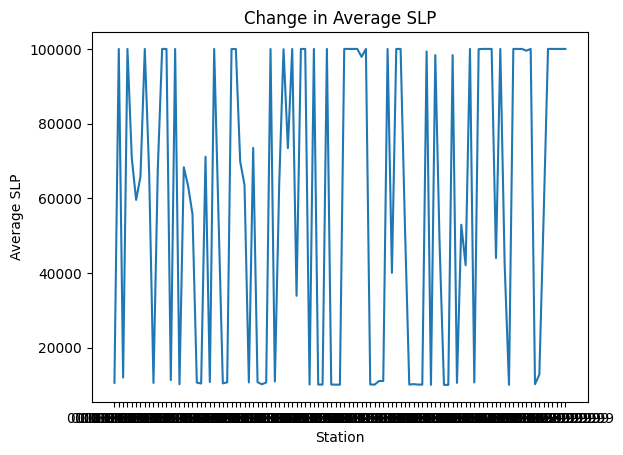

Specific configuration took 76.65 seconds


In [12]:
import matplotlib.pyplot as plt


station_slp = rdd2023_stations_avg.select("STATION", "average_SLP")
station_slp_rdd = station_slp.rdd.map(tuple)
x = station_slp_rdd.map(lambda row: row[0]).collect()
y = station_slp_rdd.map(lambda row: row[1]).collect()
plt.plot(x, y)
plt.xlabel('Station')
plt.ylabel('Average SLP')
plt.title('Change in Average SLP')

plt.show()

end = time.time()
print(f"Specific configuration took {end-start:.2f} seconds")